
# Traffic Sign Board Detection

Google Drive link for Dataset : https://drive.google.com/file/d/19EKSotNX8luEeFl1yNKAqLtCF8eAWZ4B/view?usp=sharing

The task of Recognition of Traffic Sign boards has been built using 
 

*   Python Programming Language
*   Tensorflow Framework

I have used CNN becaue , The benefit of using CNNs is their ability to develop an internal representation of a two-dimensional image. This allows the model to learn position and scale in variant structures in the data, which is important when working with images.

*This Model has **90% Accuracy.** *







Note : I have run the ipynb in Google Collab , For that reason the dataset for a online version having same number of classes but of smaller size has been uploaded to my Google Drive and liknked with Collab.

#Dataset
 
 The dataset contains 

*    39209 images
*    43 Classes
*  RGB Images

These are all made into 30x30 pixels 




In [0]:
#Following libraries and Packages have been used.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import os
import cv2

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

# Replace the assignment below with your file ID
# to download a different file.
#
# A file ID looks like: 1gLBqEWEBQDYbKCDigHnUXNTkzl-OslSO

import io
from googleapiclient.http import MediaIoBaseDownload
file_id = "19EKSotNX8luEeFl1yNKAqLtCF8eAWZ4B"
request = drive_service.files().get_media(fileId=file_id)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
  # _ is a placeholder for a progress object that we ignore.
  # (Our file is small, so we skip reporting progress.)
  _, done = downloader.next_chunk()

fileId = drive.CreateFile({'id':'19EKSotNX8luEeFl1yNKAqLtCF8eAWZ4B'})  #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
print(fileId['title'])  
fileId.GetContentFile(fileId['title'])  # Save Drive file as a local file

!unzip {fileId['title']}

gtsrb-german-traffic-sign.zip
Archive:  gtsrb-german-traffic-sign.zip
  inflating: Train.tar               
  inflating: Meta.tar                
  inflating: Meta.csv                
  inflating: Train.csv               
  inflating: Test.csv                
  inflating: Test.tar                


In [0]:
!apt-get install p7zip-full
!mkdir /content/Train
!mkdir /content/Test
!apt-get install p7zip-full
!tar -xvf Train.tar -C /content/Train
!tar -xvf Test.tar -C /content/Test

In [0]:
data_train=[]
labels_train=[]

for i in range(43) :
    path = "/content/Train/{0}/".format(i)
  
    Class=os.listdir(path)
    for a in Class:
        try:
            image=cv2.imread(path+a)
            image_from_array = Image.fromarray(image, 'RGB')
            # The images are of different size
            # this quick hack resizes them to the same size
            size_image = image_from_array.resize((30, 30))
            data_train.append(np.array(size_image))
            labels_train.append(i)
        except AttributeError:
            print(" ")

In [41]:
size_image

In [0]:
data=data_train
labels=labels_train

  

In [39]:
len(data)


39209

In [28]:
len(data[0])

30

In [19]:
len(labels)

39209

In [0]:
Cells=np.array(data)
labels=np.array(labels)

np.save("Cells",Cells)
np.save("labels",labels)

In [21]:
Cells.shape

(39209, 30, 30, 3)

In [0]:
Cells=np.load("Cells.npy")
labels=np.load("labels.npy")

In [0]:
s=np.arange(Cells.shape[0])
np.random.seed(43)
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

len_data=len(Cells)

In [0]:

# Another test/train split of the (original) train data. 
# The Test.tar-date is not used yet, but should be used
#   as the evaluation data at the end of the analysis
(X_train,X_test)=Cells[(int)(0.2*len_data):],Cells[:(int)(0.2*len_data)]
X_train = X_train.astype('float32')/255 
X_test = X_test.astype('float32')/255
train_len=len(X_train)
test_len=len(X_test)
(y_train,y_test)=labels[(int)(0.2*len_data):],labels[:(int)(0.2*len_data)]

In [0]:
X_train = X_train.reshape(-1, 30*30*3)
X_test = X_test.reshape(-1,30*30*3)

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
from io import open

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [0]:
height = 30
width = 30
channels = 3
n_inputs = height * width*channels

conv1_fmaps = 4 
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 8
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 32 # 64
n_outputs = 43

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [0]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [36]:
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)
        
    final_prediction = Y_proba.eval(feed_dict={X: X_test})

0 Last batch accuracy: 0.45 Test accuracy: 0.4792756
1 Last batch accuracy: 0.74 Test accuracy: 0.70399183
2 Last batch accuracy: 0.69 Test accuracy: 0.7638056
3 Last batch accuracy: 0.89 Test accuracy: 0.82425714
4 Last batch accuracy: 0.89 Test accuracy: 0.8445351
5 Last batch accuracy: 0.91 Test accuracy: 0.8680015
6 Last batch accuracy: 0.91 Test accuracy: 0.8850912
7 Last batch accuracy: 0.95 Test accuracy: 0.88649404
8 Last batch accuracy: 0.92 Test accuracy: 0.8942737
9 Last batch accuracy: 0.94 Test accuracy: 0.9049866


In [0]:
# The confusion matrix plotting function is from the sklearn documentation below:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=75) 
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_names = range(43)

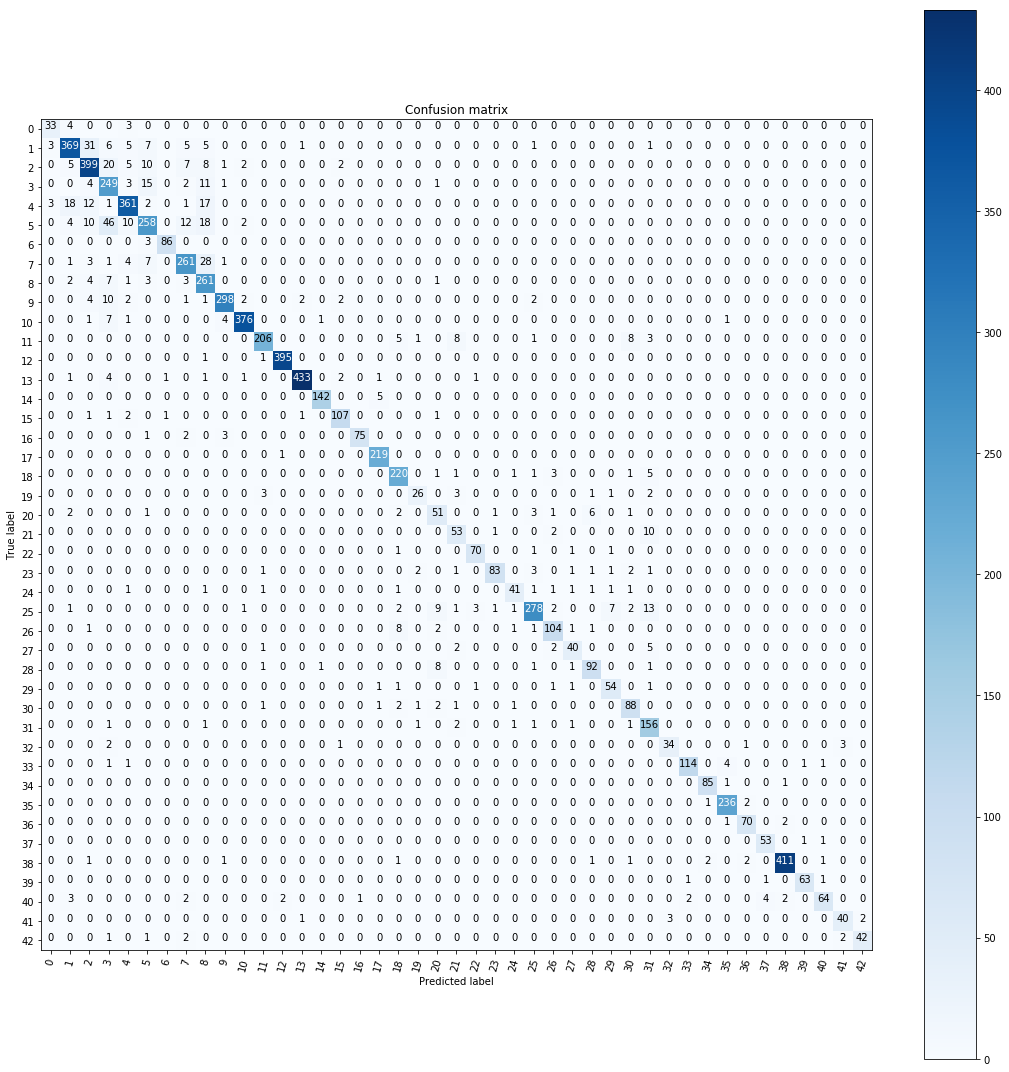

In [38]:
# evaluate the output in a confusion matrix. 
plt.figure(figsize=(15,15))
cm = confusion_matrix(y_test,np.argmax(final_prediction, axis=1))
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')